In [1]:
import os
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from metric import getMetric
import imagehash
from torchvision import transforms

In [2]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [3]:
train.shape, test.shape

((34250, 5), (3, 4))

In [7]:
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [8]:
train.head(3)

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"


### Image

In [6]:
train.image.nunique()

32412

In [7]:
img_list = sorted(glob('dataset/train_images/*.jpg'))
len(img_list)

32412

In [8]:
sizes = []
for img_path in img_list:
    img = Image.open(img_path)
    sizes.append(img.size)

In [10]:
unique_sizes = set(sizes)

### Title

(array([1.0762e+04, 1.5593e+04, 7.5340e+03, 2.8400e+02, 5.3000e+01,
        1.2000e+01, 9.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  5. ,  40.2,  75.4, 110.6, 145.8, 181. , 216.2, 251.4, 286.6,
        321.8, 357. ]),
 <BarContainer object of 10 artists>)

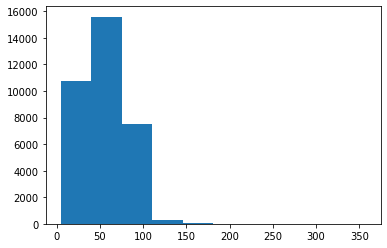

In [7]:
tmp = train.title.str.len()
plt.hist(tmp)

In [17]:
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [9]:
train.to_csv('dataset/train_mod.csv', index=False)

In [24]:
train.title.str.len().describe()

count    34250.000000
mean        56.163474
std         25.100492
min          5.000000
25%         36.000000
50%         53.000000
75%         73.000000
max        357.000000
Name: title, dtype: float64

### PHash

In [5]:
train.image_phash.str.len().describe()

count    34250.0
mean        16.0
std          0.0
min         16.0
25%         16.0
50%         16.0
75%         16.0
max         16.0
Name: image_phash, dtype: float64

In [6]:
phash_arr = train.image_phash.values

In [7]:
max_char = ''
for h in phash_arr:
    mh = max(h)
    max_char = max(max_char, mh)
max_char

'f'

Resize image will change the perceptual hash

In [11]:
img = Image.open('./dataset/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
tmp = imagehash.phash(img)
str(tmp)

'94974f937d4c2433'

In [15]:
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
])
transformed_image = img_transforms(img)
tmp2 = imagehash.phash(transformed_image)
str(tmp2)

'94974f837d4c2473'

In [16]:
train.image_phash.nunique()

28735

In [17]:
train['phash_group_num'] = train.groupby('image_phash').label_group.transform('nunique')
train[train.phash_group_num > 1].image_phash.nunique()

147

### Baseline

#### Image phash baseline

In [12]:
tmp = train.groupby('image_phash').posting_id.agg('unique').to_dict()
train['oof'] = train.image_phash.map(tmp)

In [13]:
train['f1'] = train.apply(getMetric('oof'),axis=1)
print('CV score for baseline =',train.f1.mean())

CV score for baseline = 0.5530933399168149


In [14]:
train.head()

,posting_id,image,image_phash,title,label_group,target,oof,f1
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",[train_129225211],0.666667
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",[train_3386243561],0.666667
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",[train_2288590299],0.666667
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165],0.666667
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],0.666667
